Mario Bello - Miguel Bielsa - Marta Pascual - María Sancho

#**EJERCICIO 2: VECTORIZACIÓN, MODELOS DE CLASIFICACIÓN Y ANÁLISIS DE RESULTADOS**

En este segundo cuaderno, tras haber estudiado la base de datos en el primero, se va a presentar el resto del trabajo siguiendo la siguiente estructura:

1.- Procesado de la base de datos: limpieza, homogeneización y tokenización.

2.- Vectorización TF-IDF, Word2Vec y Embeddings contextuales (BERTa, RoBERTa, etc.).

3.- Algoritmos de clasificación de regresión logística y SVM.

4.- Redes neuronales para los 3 métodos de vectorización.

5.- Transformer RoBERTa + Fine-Tunning.


Para ello, primero importamos todas las librerías que vamos a utilizar e instalamos las extensiones necesarias (así evitamos "ensuciar" el código)

In [ ]:
# IMPORTAMOS TODAS LAS LIBRERÍAS NECESARIAS PARA LA EJECUCIÓN DEL DOCUMENTO
!pip install contractions -q
!pip install gensim -q

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import contractions
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import corpus2csc
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

from datasets import Dataset
from transformers import AutoTokenizer, AutoModel, logging, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

Empezamos cargando la base de datos y guardándonos las variables de las columnas del dataset que vamos a utilizar a lo largo del cuaderno (no se comentará nada más de la base de datos, ya que ya se ha hecho un análisis en profundidad en el primer cuaderno).

In [ ]:
database = pd.read_excel('fake_new_dataset.xlsx')

# Reemplazamos las palabras viru y coronaviru por virus y coronavirus (problema que encontramos en el primer cuaderno de análisis del dataset)
correcciones = {
    r'\bviru\b': 'virus',
    r'\bcoronaviru\b': 'coronavirus'
}

for wrong, correct in correcciones.items():
    database['text'] = database['text'].str.replace(wrong, correct, regex=True)

news=database['text'] # Noticias de la base de datos
etiquetas=database['label'] # Etiquetas binarias: 1-true, 0-false/partially false
etiquetas_rnn = database['label'].values # Etiquetas binarias: 1-true, 0-false/partially false
categoria=database['subcategory'] # true, false news o partially false
categoria=categoria.replace("false news","false") # Cambiamos false news solo por false para hacerlo más limpio


A modo de resumen del cuaderno anterior, estos son los parámetros más importantes en términos de número total de noticias y de cuántas tenemos de cada categoría.

In [ ]:
number_news=news.size
number_true_news=np.sum(categoria=="true")
number_false_news=np.sum(categoria=="false")
number_partially_false_news=np.sum(categoria=="partially false")

print("Número total de noticias en la database: "+str(number_news))
print("Número de noticias verdaderas en la database: "+str(number_true_news))
print("Número de noticias falsas en la database: "+str(number_false_news))
print("Número de noticias parcialmente falsas en la database: "+str(number_partially_false_news))

# Comprobación de que tenemos todas las filas clasificadas
print(number_true_news+number_false_news+number_partially_false_news)

Número total de noticias en la database: 3119
Número de noticias verdaderas en la database: 2061
Número de noticias falsas en la database: 659
Número de noticias parcialmente falsas en la database: 399
3119




---


#**PROCESADO PREVIO DE LA BASE DE DATOS**


---



En nuestro caso, el dataset está compuesto por noticias "crudas" sacadas de diferentes artículos, periódicos digitales, etc, ... por lo que es importante un procesado previo de las mismas para no confundir a nuestros modelos con tokens que no vayan a aportar nada.

Para ello, primero eliminamos todas las urls y los etiquetas html que aparecen en las diferentes noticias.

In [ ]:
# Esta función elimina las etiquetas html que puedan contener y las urls que puedan aparecer
def remove_html_url(text):

    # Eliminamos las etiquetas html
    soup = BeautifulSoup(text, "lxml")
    text = soup.get_text()

    # Eliminamos las url
    text = re.sub(r'https://\S+|www\.\S+', '', text)
    text = contractions.fix(text)

    return text

news_clean=news.apply(remove_html_url)
news_modified=np.sum(news!=news_clean)

print(f" Se han modificado {news_modified} noticias")

 Se han modificado 1791 noticias


A continuación, y antes de realizar la tokenización, hacemos una segunda limpieza de nuestras noticias. En este caso, homogeneizamos todo el texto en minúsculas y eliminamos posibles caracteres no alfanúmericos como #,€, etc.

In [ ]:
def homogeneizacion(text):
    text = text.lower() # Pasamos a minúsculas

    # Eliminar caracteres no alfanuméricos usando isalnum
    text = "".join([c if c.isalnum() or c.isspace() else " " for c in text])

    return text

news_clean=news.apply(homogeneizacion)

Una vez limpia nuestra base de datos, creamos la función *tokenization*, que como su propio nombre indica, separa las noticias en tokens, que deberemos utilizar luego para Word2Vec, BOW, etc.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def tokenization(text):
    text = text.lower() # Pasamos a minúsculas

    # Eliminar caracteres no alfanuméricos usando isalnum
    text = "".join([c if c.isalnum() or c.isspace() else " " for c in text])

    tokens = word_tokenize(text) # Tokenizamos
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2] # eliminamos signos de puntuación y palabras/números cortos

    return tokens

# Hallamos los tokens de las noticias ya limpias
news_tokenized = [tokenization(t) for t in news_clean]

# News tokenized es una lista con 3119 noticias y cada noticia con x palabras


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
print("Ejemplo de tokens de nuestro dataset para la primera noticia: \n")
print(news_tokenized[0][0:5])

Ejemplo de tokens de nuestro dataset para la primera noticia: 

['facebook', 'shuttered', 'popular', 'group', 'michiganders']




---


#**EJERCICIO 2: REPRESENTACIÓN VECTORIAL DEL TEXTO**


---



Realizado el procesado de la base de datos, se van a presentar en este segundo ejercicio las vectorizaciones TF-IDF, Word2Vec y Embeddings contextuales, que nos servirán para transformar nuestras noticias del dataset en entradas numéricas adecuadas que sirvan luego para entrenar los diferentes modelos que se van a presentar.



---


TF-IDF


---



La primera de las técnicas de vectorización que se va a implementar es TF-IDF. Para ello, se van a proponer 2 opciones diferentes.

La primera de ellas es utilizando gensim de python. Para ello, creamos nuestro diccionario con las noticias tokenizadas y creamos la representación Bag of Words.

In [ ]:
#OPCIÓN 1
# Crear diccionario
D = Dictionary(news_tokenized)

# Crear representación BoW
tokens_bow = [D.doc2bow(p) for p in news_tokenized]


In [ ]:
print(f"Ejemplo de BoW para el primer documento: '{tokens_bow[0]}'")
# En el print, se muestran para el primer documento (primera noticia), una lista con las tuplas (id. palabra,nº apariciones)

Ejemplo de BoW para el primer documento: '[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 3), (32, 1), (33, 2), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 4), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 4), (81, 1), (82, 1), (83, 7), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 5), (105, 1), (106, 1

Posteriormente, con la representación BoW utilizamos la librería gensim para crear nuestro modelo TF-IDF.

In [ ]:
# Crear modelo TF-IDF
model_tfidf=TfidfModel(tokens_bow)

# Transformar corpus BoW en TF-IDF
reviews_tfidf=model_tfidf[tokens_bow]

# Convierte el corpus TF-IDF a sparse matrix (columnas = documentos, filas = features)
X_sparse = corpus2csc(reviews_tfidf)

# Transponemos para que shape sea (n_docs, n_features)
X = X_sparse.T

print(f"Tamaño del database: {X.shape}")

Tamaño del database: (3119, 37385)


Para esta primera opción, podemos ver un vocabulario muy extenso (de hasta 37000 palabras), que podríamos reducir filtrando el diccionario por número de apariciones en el documento, etc. Sin embargo, finalmente hemos utilizado la opción que se va a presentar a continuación, luego haremos el filtrado en esta segunda opción.

La librería sklearn ofrece ya un modelo que realiza directamente la tokenización y la vectorización TF-IDF de manera interna. Por ello, le pasamos a dicha librería las noticias limpias (tras eliminar las urls y homogeneizar los textos), y nos generará el modelo que vamos a utilizar de aquí en adelante.

Uno de los motivos por los que hemos utilizado esta librería (además de por la simplicidad), es que se puede filtrar el vocabulario directamente mediante los parámetros de entrada max_df y min_df y no debemos hacerlo al generar el diccionario en el BoW. No obstante, hemos comprobado que para los modelos de clasificación que se presentarán más adelante, la diferencia entre usar una opción u otra es prácticamente nula.

In [ ]:
# OPCIÓN 2:Utilizando directamente sklearn:

# Estaa función te hace ya la tokenización y la vectorización
tfidf_model = TfidfVectorizer(lowercase=True, stop_words='english', token_pattern=r'\b\w\w+\b',max_df=0.6,min_df=10)
X_tfidf = tfidf_model.fit_transform(news_clean)

print(f"Tamaño del database: {X_tfidf.shape}")

Tamaño del database: (3119, 7158)


Podemos ver como hemos reducido el vocabulario desde 37386 palabras hasta 7158, pues hemos eliminado las palabras que aparecen en menos de 10 documentos y aquellas que aparecen en más del 60%, pues realmente no van a aportar información clara a nuestros modelos.



---

Word2Vec


---

El segundo de los métodos de vectorización es Word2Vec. Empezamos entrenando un modelo Word2Vec a partir de los textos tokenizados. El modelo aprende representaciones vectoriales para cada palabra. Además, se muestra el tamaño del vocabulario aprendido y ejemplos de embeddings de palabras.



In [ ]:
#entrenamiento del modelo sobre las noticias tokenizadas

# Entrenamos el modelo Word2Vec
model_w2v = Word2Vec(
    sentences=news_tokenized,  # nuestras noticias ya tokenizadas
    vector_size=100,           # dimensión del embedding
    window=5,                  # tamaño de la ventana de contexto
    min_count=10,              # ignora palabras muy poco frecuentes
    workers=4,                 # núm. de hilos
    sg=1
)

print("Tamaño del vocabulario Word2Vec:", len(model_w2v.wv))

# Miramos algunas palabras y el embedding de la primera
palabras_w2v = list(model_w2v.wv.key_to_index)
print("Primeras 20 palabras del vocabulario Word2Vec:")
print(palabras_w2v[:20])

print("Embedding de la primera palabra del vocabulario:")
print(model_w2v.wv[palabras_w2v[0]])

Tamaño del vocabulario Word2Vec: 8472
Primeras 20 palabras del vocabulario Word2Vec:
['virus', 'china', 'coronavirus', 'health', 'people', 'said', 'corona', 'cases', 'wuhan', 'new', '2019', 'also', 'chinese', 'outbreak', 'ncov', 'one', 'spread', 'disease', 'world', 'public']
Embedding de la primera palabra del vocabulario:
[-0.03131872 -0.05290854  0.24698988 -0.07471697 -0.31022424 -0.2831011
  0.05290119  0.674708   -0.13108537 -0.04042802  0.22446594 -0.11450067
 -0.00291741  0.37323478  0.02501496 -0.6263709   0.3052999   0.08306754
  0.1889552  -0.7160774   0.30468312 -0.204829    0.37282103  0.11231006
  0.11877439 -0.05759479  0.35246304 -0.24801661 -0.2710242  -0.14404011
  0.09866864 -0.26182976  0.39800367 -0.18637617  0.08598097 -0.27389044
 -0.01164656 -0.05491856 -0.19503985 -0.11692458 -0.0761861  -0.05674412
 -0.18115316  0.0115724   0.30770364 -0.07557856 -0.14971691 -0.10123172
 -0.11918     0.39257884  0.13282189 -0.27650538 -0.57014406 -0.08335079
 -0.13966656  0.064

Representación de documentos como la media de los embeddings

Generamos un vector para cada documento calculando la media de los embeddings de todas sus palabras presentes en el modelo Word2Vec. Esto transforma cada noticia en una representación numérica fija que resume su contenido y puede emplearse posteriormente como entrada para modelos de clasificación.

In [ ]:
#Word2Vec: representación de documentos como media de los embeddings de sus palabras

def document_embedding(tokens, model):
  vectores_palabras = []

  for t in tokens:
      if t in model.wv:  # solo usamos palabras que estén en el vocabulario
          vectores_palabras.append(model.wv[t])

  if len(vectores_palabras) == 0:
      # si ninguna palabra del documento está en el vocabulario,devolvemos un vector de ceros
      return np.zeros(model.vector_size)

  # media de todos los embeddings de las palabras del documento
  return np.mean(vectores_palabras, axis=0)

# Calculamos el embedding de cada noticia
docs_w2v = np.array([document_embedding(doc, model_w2v) for doc in news_tokenized])

print("Shape de la matriz de documentos (Word2Vec):", docs_w2v.shape)
print("Primeros 10 valores del primer documento:")
print(docs_w2v[0][:10])

Shape de la matriz de documentos (Word2Vec): (3119, 100)
Primeros 10 valores del primer documento:
[-0.11521283 -0.01547442  0.02636909 -0.00709357  0.08537958  0.01531873
 -0.09919412  0.24048771 -0.23878525  0.02824002]




---


Embeddings contextuales


---



En la tercera estrategia de representación vectorial vamos a emplear embeddings contextuales obtenidos mediante modelos Transformer. Existen múltiples variantes de estos modelos, cada una con diferentes compromisos entre precisión y coste computacional. Para este proyecto consideramos tres opciones habituales:

*   **DistilBERT:** versión reducida y optimizada de BERT.
*   **BERT base:** modelo clásico, de tamaño intermedio, ampliamente utilizado como referencia.
*  **RoBERTa base:** variante mejorada de BERT, generalmente con mayor rendimiento pero más costosa computacionalmente.

Primero, creamos una función para que pasado un modelo de transformer calcule la vectorización.

In [ ]:
# Función general para obtener embeddings contextuales de un modelo Transformer
def get_transformer_embeddings(model_name, texts, max_length=128, batch_size=16):
    """
    model_name : string del modelo de HuggingFace (p.ej. 'roberta-base')
    texts      : lista o Serie de textos (usaremos news_clean)
    max_length : truncamos las secuencias a esta longitud
    batch_size : tamaño del batch para no petar memoria
    """

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Nos aseguramos de que 'texts' sea una lista de strings
    if hasattr(texts, "tolist"):
        texts = texts.tolist()

    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]

        all_embeddings.append(cls_embeddings.cpu().numpy())

    # Unimos todos los batches
    embeddings = np.vstack(all_embeddings)

    # Prints finales limpios (para el notebook / memoria)
    print(f"Modelo utilizado: {model_name}")
    print(f"Dimensión del embedding: {embeddings.shape[1]}")
    print(f"Matriz final de documentos: {embeddings.shape}")

    return embeddings


A continuación, en lugar de aplicar directamente los tres modelos mencionados antes sobre el conjunto completo, realizamos un experimento parcial de selección de modelo. El objetivo es identificar cuál de las tres opciones ofrece el mejor rendimiento preliminar en nuestra tarea de clasificación de noticias falsas, para así utilizar solo ese modelo en el resto del flujo de trabajo.

In [ ]:
#ignorar warnings que no nos aplican
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

# Diccionario con los tres modelos que queremos probar
modelos_transformer = { #"nombre_corto(alias)":"nombre_hf"
    "distilbert": "distilbert-base-uncased",
    "bert": "bert-base-uncased",
    "roberta": "roberta-base"
}

#Seleccionamos un subconjunto aleatorio de noticias
n_subset = min(500, len(news_clean))
rng = np.random.RandomState(42)
indices_subset = rng.choice(len(news_clean), size=n_subset, replace=False)

X_subset = news_clean.iloc[indices_subset].reset_index(drop=True)
y_subset = categoria.iloc[indices_subset].reset_index(drop=True)

print("Tamaño del subset que vamos a utilizar:", n_subset)

# Calculamos embeddings y entrenamos un clasificador en nuestro caso Logistic Regression para cada modelo
resultados = {}
embeddings_modelos = {}
i=1
for nombre_corto, model_name in modelos_transformer.items():
    print(f"\nOpción {i}) {nombre_corto}  ({model_name})")
    i += 1
    # Embeddings del subset
    docs_emb = get_transformer_embeddings(
        model_name,
        X_subset,
        max_length=128,
        batch_size=16
    )

    embeddings_modelos[nombre_corto] = docs_emb

    # Train/validation split sobre los embeddings
    X_tr, X_val, y_tr, y_val = train_test_split(
        docs_emb,
        y_subset,
        test_size=0.2,
        random_state=42,
        stratify=y_subset
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_val)
    # calculamos en accuracy como métrica para compararlos
    acc = accuracy_score(y_val, y_pred)
    resultados[nombre_corto] = acc

    print(f"Accuracy en validación para {nombre_corto}: {acc:.4f}")


Tamaño del subset que vamos a utilizar: 500

Opción 1) distilbert  (distilbert-base-uncased)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Modelo utilizado: distilbert-base-uncased
Dimensión del embedding: 768
Matriz final de documentos: (500, 768)
Accuracy en validación para distilbert: 0.6200

Opción 2) bert  (bert-base-uncased)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Modelo utilizado: bert-base-uncased
Dimensión del embedding: 768
Matriz final de documentos: (500, 768)
Accuracy en validación para bert: 0.6800

Opción 3) roberta  (roberta-base)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Modelo utilizado: roberta-base
Dimensión del embedding: 768
Matriz final de documentos: (500, 768)
Accuracy en validación para roberta: 0.7000


In [ ]:
print("\nResultados finales de la prueba parcial:")
for nombre_corto, acc in resultados.items():
    print(f"  {nombre_corto}: {acc:.4f}")

# Seleccionamos el mejor modelo según la accuracy obtenida
mejor_modelo_corto = max(resultados, key=resultados.get)
mejor_modelo_hf = modelos_transformer[mejor_modelo_corto]

print(f"El mejor modelo es {mejor_modelo_corto} ({mejor_modelo_hf})")
print(f"Accuracy de validación: {resultados[mejor_modelo_corto]:.4f}")


Resultados finales de la prueba parcial:
  distilbert: 0.6200
  bert: 0.6800
  roberta: 0.7000
El mejor modelo es roberta (roberta-base)
Accuracy de validación: 0.7000


Como podemos observar, el mejor modelo es RoBERTa y lo aplicamos a todas las noticias

In [ ]:
# Embeddings contextuales con RoBERTa para todas las noticias
docs_roberta = get_transformer_embeddings(
    modelos_transformer["roberta"],  # esto ahora es 'roberta-base'
    news_clean,
    max_length=128,
    batch_size=16
)

Modelo utilizado: roberta-base
Dimensión del embedding: 768
Matriz final de documentos: (3119, 768)




---


#**EJERCICIO 3: MODELADO Y EVALUACIÓN**


---



Para empezar, dividimos nuestra base de datos en 3 subconjuntos de train, text y validación, a los que se aplicarán cada una de las técnicas de vectorización vistas en el ejercicio 2 para la evaluación de diferentes modelos de clasificación.

Es importante destacar que, después de diferentes pruebas, hemos decidido reducir la clasificación a true/false, suprimiendo la categoría intermedia de partially false. Es una categoría minoritaria que no cuenta con las suficientes muestras como para que los modelos la aprendan. Además, aunque para los primeros modelos de clasificación de Scikit-learn la degradación no es tan evidente (en torno a un 4% de accuracy), para la red neuronal y el modelo preentrenado + fine-tunning, los resultados para clasificación binaria son mucho mejores.

In [ ]:
# Codificamos las etiquetas de texto ('true', 'false', 'partially false') a enteros
# Estas lineas se utilizarían para probar clasificación con 3 clases (no se utilizan actualmente en el código)
le = LabelEncoder()
Y_multietiqueta = le.fit_transform(categoria)

# Primera separación: dejamos un 20% como test
X_p, X_tst, y_p, Y_tst = train_test_split(
    news_clean,
    etiquetas,
    test_size=0.2,
    random_state=42,
    stratify=etiquetas
)

# Segunda separación: de lo que queda, reservamos un 25% para validación
# (en total: 60% train, 20% val, 20% test)

X_trn, X_val, Y_trn, Y_val = train_test_split(
    X_p,
    y_p,
    test_size=0.25,
    random_state=42,
    stratify=y_p
)


De esta forma, ya tenemos nuestras variables X_trn / Y_trn, X_tst / Y_tst y X_val / Y_val que utilizaremos en la siguiente sección para evaluar la calidad de nuestros modelos. Destacar que, como veíamos en el primer cuaderno de análisis del dataset, el número de noticias true es mucho mayor que false/partially false, luego utilizamos 'stratify' para que se repartan dichas noticias proporcionalmente en los 3 conjuntos de train,test y validación.

A continuación, para evaluar el correcto funcionamiento de las 3 vectorizaciones presentadas en el punto anterior hemos empleado 2 modelos de clasificación (Regresión logística y SVM). Primero, se presentarán los resultados por separado de cada uno de los métodos para las 3 vectorizaciones, extrayendo algunas conclusiones iniciales. Finalmente, y antes de saltar a las redes neuronales, se hará un resumen y comparación de los resultados para todos los casos.



---


##**Primer modelo de clasificación: Regresión logística**


---



Comenzando con la regresión logística, el primer paso es definir nuestro modelo que utilizaremos para cada una de las 3 vectorizaciones. Los resultados se presentan por separado para TF-IDF, Word2Vec y Embeddings contextuales.

In [ ]:
# Inicializamos nuestro modelo de regresión logística
log_reg = LogisticRegression(
    max_iter=1000,
    C=1.0,
    n_jobs=-1
)




---


Para vectorización TF-IDF

---



In [ ]:
# Ajustamos el modelo que hemos definido en el ejercicio 2 con nuestras variables de train, test y validación

X_trn_tfidf=tfidf_model.fit_transform(X_trn)
X_val_tfidf=tfidf_model.transform(X_val)
X_tst_tfidf=tfidf_model.transform(X_tst)

# Entrenamos el modelo con el conjunto de entrenamiento
log_reg.fit(X_trn_tfidf, Y_trn)

# Predicciones en train, val y test
D_trn_tfidf = log_reg.predict(X_trn_tfidf)
D_val_tfidf = log_reg.predict(X_val_tfidf)
D_tst_tfidf = log_reg.predict(X_tst_tfidf)

# Error rate (proporción de ejemplos mal clasificados)
pe_trn_tfidf = np.mean(D_trn_tfidf != Y_trn)
pe_val_tfidf = np.mean(D_val_tfidf != Y_val)
pe_tst_tfidf = np.mean(D_tst_tfidf != Y_tst)

print("Error rate Regresión Logística con embeddings TF-IDF:")
print(f"- Training:   {pe_trn_tfidf:.4f}")
print(f"- Validation: {pe_val_tfidf:.4f}")
print(f"- Test:       {pe_tst_tfidf:.4f}")

# Mostramos también la accuracy
acc_trn_tfidf = 1 - pe_trn_tfidf
acc_val_tfidf = 1 - pe_val_tfidf
acc_tst_tfidf = 1 - pe_tst_tfidf

print("\nAccuracy Regresión Logística (TF-IDF):")
print(f"- Training:   {acc_trn_tfidf:.4f}")
print(f"- Validation: {acc_val_tfidf:.4f}")
print(f"- Test:       {acc_tst_tfidf:.4f}")

Error rate Regresión Logística con embeddings TF-IDF:
- Training:   0.1229
- Validation: 0.2196
- Test:       0.2067

Accuracy Regresión Logística (TF-IDF):
- Training:   0.8771
- Validation: 0.7804
- Test:       0.7933


Para TF-IDF, quizá la vectorización más sencilla, ya que trabaja únicamente con la frecuencia de aparición de las palabras en el grueso de los documentos, los resultados de accuracy son relativamente buenos. Como era de esperar, en el conjunto de entrenamiento se alcanzan valores en torno al 87%, que se reduce hasta el 78% para los conjuntos de test y validación.



---


Para vectorización Word2Vec


---

Entrenamos un clasificador de Regresión Logística utilizando los embeddings Word2Vec como entrada. Calculamos las tasas de error y accuracy en train, validación y test para evaluar el rendimiento del modelo sobre esta representación vectorial.


In [ ]:
# Ajustamos el modelo que hemos definido en el ejercicio 2 usando Word2Vec
# Creamos las matrices de características Word2Vec para train, val y test,
# usando los mismos índices que en X_trn, X_val y X_tst

X_trn_w2v = docs_w2v[X_trn.index]
X_val_w2v = docs_w2v[X_val.index]
X_tst_w2v = docs_w2v[X_tst.index]

# Entrenamos el modelo con el conjunto de entrenamiento (Word2Vec)
log_reg.fit(X_trn_w2v, Y_trn)

# Predicciones en train, val y test
D_trn_w2v = log_reg.predict(X_trn_w2v)
D_val_w2v = log_reg.predict(X_val_w2v)
D_tst_w2v = log_reg.predict(X_tst_w2v)

# Error rate (proporción de ejemplos mal clasificados)
pe_trn_w2v = np.mean(D_trn_w2v != Y_trn)
pe_val_w2v = np.mean(D_val_w2v != Y_val)
pe_tst_w2v = np.mean(D_tst_w2v != Y_tst)

print("Error rate Regresión Logística con embeddings Word2Vec:")
print(f"- Training:   {pe_trn_w2v:.4f}")
print(f"- Validation: {pe_val_w2v:.4f}")
print(f"- Test:       {pe_tst_w2v:.4f}")

# Mostramos también la accuracy
acc_trn_w2v = 1 - pe_trn_w2v
acc_val_w2v = 1 - pe_val_w2v
acc_tst_w2v = 1 - pe_tst_w2v

print("\nAccuracy Regresión Logística (Word2Vec):")
print(f"- Training:   {acc_trn_w2v:.4f}")
print(f"- Validation: {acc_val_w2v:.4f}")
print(f"- Test:       {acc_tst_w2v:.4f}")


Error rate Regresión Logística con embeddings Word2Vec:
- Training:   0.1903
- Validation: 0.1987
- Test:       0.1955

Accuracy Regresión Logística (Word2Vec):
- Training:   0.8097
- Validation: 0.8013
- Test:       0.8045


De forma similar a lo que ocurría para TF-IDF, el accuracy para Word2Vec se encuentra ahora en torno al 80%. Es decir, que a pesar de ser una vectorización más compleja e 'inteligente' (en términos de aprender relaciones semánticas), los resultados apenas mejoran respecto a TF-IDF para el clasificador con regresión logística. Si bien es cierto que se ha conseguido un accuracy igual para test y validación y para entrenamiento.



---


Para vectorización por embeddings contextuales


---



Entrenamos un clasificador de Regresión Logística utilizando los embeddings RoBERTA como entrada. Calculamos las tasas de error y accuracy en train, validación y test para evaluar el rendimiento del modelo sobre esta representación vectorial.

In [ ]:
# Ajustamos el modelo que hemos definido en el ejercicio 2 usando RoBERTa
# Creamos las matrices de características RoBERTa para train, val y test,
# usando los mismos índices que en X_trn, X_val y X_tst

X_trn_roberta = docs_roberta[X_trn.index]
X_val_roberta = docs_roberta[X_val.index]
X_tst_roberta = docs_roberta[X_tst.index]

# Entrenamos el modelo con el conjunto de entrenamiento (RoBERTa)
log_reg.fit(X_trn_roberta, Y_trn)

# Predicciones en train, val y test
D_trn_roberta = log_reg.predict(X_trn_roberta)
D_val_roberta = log_reg.predict(X_val_roberta)
D_tst_roberta = log_reg.predict(X_tst_roberta)

# Error rate (proporción de ejemplos mal clasificados)
pe_trn_roberta = np.mean(D_trn_roberta != Y_trn)
pe_val_roberta = np.mean(D_val_roberta != Y_val)
pe_tst_roberta = np.mean(D_tst_roberta != Y_tst)

print("Error rate Regresión Logística con embeddings RoBERTa:")
print(f"- Training:   {pe_trn_roberta:.4f}")
print(f"- Validation: {pe_val_roberta:.4f}")
print(f"- Test:       {pe_tst_roberta:.4f}")

# Mostramos también la accuracy
acc_trn_roberta = 1 - pe_trn_roberta
acc_val_roberta = 1 - pe_val_roberta
acc_tst_roberta = 1 - pe_tst_roberta

print("\nAccuracy Regresión Logística (RoBERTa):")
print(f"- Training:   {acc_trn_roberta:.4f}")
print(f"- Validation: {acc_val_roberta:.4f}")
print(f"- Test:       {acc_tst_roberta:.4f}")


Error rate Regresión Logística con embeddings RoBERTa:
- Training:   0.1988
- Validation: 0.2244
- Test:       0.2340

Accuracy Regresión Logística (RoBERTa):
- Training:   0.8012
- Validation: 0.7756
- Test:       0.7660


Al comparar los resultados obtenidos con Word2Vec y con embeddings contextuales RoBERTa utilizando un clasificador de Regresión Logística, se observa que las diferencias en accuracy son reducidas. En particular, Word2Vec obtiene un rendimiento ligeramente superior en el conjunto de test, mientras que RoBERTa presenta valores similares aunque algo inferiores.

Este comportamiento puede explicarse por el carácter lineal del clasificador empleado. Aunque los embeddings contextuales de RoBERTa contienen información semántica más rica, la Regresión Logística no es capaz de explotar completamente esta complejidad. En este contexto, representaciones más simples como Word2Vec resultan igualmente eficaces.

Estos resultados muestran que el uso de representaciones más avanzadas no garantiza necesariamente mejoras en el rendimiento cuando se emplean modelos de clasificación simples, y refuerzan la necesidad de utilizar modelos más expresivos o técnicas de fine-tuning para aprovechar todo el potencial de los modelos Transformer.



---


##**Segundo modelo de clasificación: SVM**


---



En segundo lugar, utilizamos un segundo modelo de clasificación para intentar mejorar los resultados obtenidos antes con la ref¡gresión logística, para lo cual utilizamos un modelo SVM (Support Vector Machines).

In [ ]:
# Inicializamos nuestro modelo SVM lineal

SVM_model = SVC(
    kernel='linear',
    C=1.0,
    probability=False
)


Igual que antes, se presentan primero los resultados por separado para TF-IDF, Word2Vec y Embeddings contextuales para presentar luego algunas conclusiones conjuntas y una comparativa final con el método de regresión logística.



---


Para vectorización TF-IDF

---



In [ ]:
# Entrenamos el modelo con el conjunto de entrenamiento
SVM_model.fit(X_trn_tfidf, Y_trn)

# Predicciones en train, val y test
D_trn_svm_tfidf = SVM_model.predict(X_trn_tfidf)
D_val_svm_tfidf = SVM_model.predict(X_val_tfidf)
D_tst_svm_tfidf = SVM_model.predict(X_tst_tfidf)

# Error rate
pe_trn_svm_tfidf = np.mean(D_trn_svm_tfidf != Y_trn)
pe_val_svm_tfidf = np.mean(D_val_svm_tfidf != Y_val)
pe_tst_svm_tfidf = np.mean(D_tst_svm_tfidf != Y_tst)

print("Error rate SVM lineal con embeddings TF-IDF:")
print(f"- Training:   {pe_trn_svm_tfidf:.4f}")
print(f"- Validation: {pe_val_svm_tfidf:.4f}")
print(f"- Test:       {pe_tst_svm_tfidf:.4f}")

# Accuracy
acc_trn_svm_tfidf = 1 - pe_trn_svm_tfidf
acc_val_svm_tfidf = 1 - pe_val_svm_tfidf
acc_tst_svm_tfidf = 1 - pe_tst_svm_tfidf

print("\nAccuracy SVM lineal (TF-IDF):")
print(f"- Training:   {acc_trn_svm_tfidf:.4f}")
print(f"- Validation: {acc_val_svm_tfidf:.4f}")
print(f"- Test:       {acc_tst_svm_tfidf:.4f}")

Error rate SVM lineal con embeddings TF-IDF:
- Training:   0.0759
- Validation: 0.2131
- Test:       0.2099

Accuracy SVM lineal (TF-IDF):
- Training:   0.9241
- Validation: 0.7869
- Test:       0.7901


Los resultados que obtenemos son muy similares a los que teníamos con regresión logística. El accuracy para el entrenamiento asciende ahora hasta el 91%, pero no se logran mantener estos valores para test y validación, donde desciende hasta cerca del 78%. Es decir, los resultados apenas mejoran respecto a la regresión logística, a pesar de utilizar, a priori, un modelo de clasificación algo más complejo y robusto al ruido.



---


Para vectorización Word2Vec


---
Entrenamos un modelo SVM lineal utilizando los embeddings Word2Vec. Igual que antes, se reportan las métricas de error y accuracy en los tres subconjuntos para comparar el rendimiento con la Regresión Logística.


In [ ]:
# Creamos las matrices Word2Vec para train, val y test usando los mismos índices
X_trn_w2v = docs_w2v[X_trn.index]
X_val_w2v = docs_w2v[X_val.index]
X_tst_w2v = docs_w2v[X_tst.index]

# Entrenamos el modelo SVM lineal con los embeddings Word2Vec
SVM_model.fit(X_trn_w2v, Y_trn)

# Predicciones en train, val y test
D_trn_svm_w2v = SVM_model.predict(X_trn_w2v)
D_val_svm_w2v = SVM_model.predict(X_val_w2v)
D_tst_svm_w2v = SVM_model.predict(X_tst_w2v)

# Error rate
pe_trn_svm_w2v = np.mean(D_trn_svm_w2v != Y_trn)
pe_val_svm_w2v = np.mean(D_val_svm_w2v != Y_val)
pe_tst_svm_w2v = np.mean(D_tst_svm_w2v != Y_tst)

print("Error rate SVM lineal con embeddings Word2Vec:")
print(f"- Training:   {pe_trn_svm_w2v:.4f}")
print(f"- Validation: {pe_val_svm_w2v:.4f}")
print(f"- Test:       {pe_tst_svm_w2v:.4f}")

# Accuracy
acc_trn_svm_w2v = 1 - pe_trn_svm_w2v
acc_val_svm_w2v = 1 - pe_val_svm_w2v
acc_tst_svm_w2v = 1 - pe_tst_svm_w2v

print("\nAccuracy SVM lineal (Word2Vec):")
print(f"- Training:   {acc_trn_svm_w2v:.4f}")
print(f"- Validation: {acc_val_svm_w2v:.4f}")
print(f"- Test:       {acc_tst_svm_w2v:.4f}")


Error rate SVM lineal con embeddings Word2Vec:
- Training:   0.1839
- Validation: 0.1955
- Test:       0.1971

Accuracy SVM lineal (Word2Vec):
- Training:   0.8161
- Validation: 0.8045
- Test:       0.8029


Las conclusiones para Word2Vec no varían respecto a las extraídas con TF-IDF. Las prestaciones son iguales o incluso ligeramente peores respecto al modelo de regresión logística.



---


Para vectorización por embeddings contextuales


---



Entrenamos un modelo SVM lineal utilizando los embeddings RoBERTA. Igual que antes, se reportan las métricas de error y accuracy en los tres subconjuntos para comparar el rendimiento con la Regresión Logística.

In [ ]:
# Ajustamos el modelo SVM usando embeddings RoBERTa
# Creamos las matrices de características RoBERTa para train, val y test,
# usando los mismos índices que en X_trn, X_val y X_tst

X_trn_roberta = docs_roberta[X_trn.index]
X_val_roberta = docs_roberta[X_val.index]
X_tst_roberta = docs_roberta[X_tst.index]

# Entrenamos el modelo con el conjunto de entrenamiento (RoBERTa)
SVM_model.fit(X_trn_roberta, Y_trn)

# Predicciones en train, val y test
D_trn_svm_roberta = SVM_model.predict(X_trn_roberta)
D_val_svm_roberta = SVM_model.predict(X_val_roberta)
D_tst_svm_roberta = SVM_model.predict(X_tst_roberta)

# Error rate
pe_trn_svm_roberta = np.mean(D_trn_svm_roberta != Y_trn)
pe_val_svm_roberta = np.mean(D_val_svm_roberta != Y_val)
pe_tst_svm_roberta = np.mean(D_tst_svm_roberta != Y_tst)

print("Error rate SVM lineal con embeddings RoBERTa:")
print(f"- Training:   {pe_trn_svm_roberta:.4f}")
print(f"- Validation: {pe_val_svm_roberta:.4f}")
print(f"- Test:       {pe_tst_svm_roberta:.4f}")

# Accuracy
acc_trn_svm_roberta = 1 - pe_trn_svm_roberta
acc_val_svm_roberta = 1 - pe_val_svm_roberta
acc_tst_svm_roberta = 1 - pe_tst_svm_roberta

print("\nAccuracy SVM lineal (RoBERTa):")
print(f"- Training:   {acc_trn_svm_roberta:.4f}")
print(f"- Validation: {acc_val_svm_roberta:.4f}")
print(f"- Test:       {acc_tst_svm_roberta:.4f}")


Error rate SVM lineal con embeddings RoBERTa:
- Training:   0.1807
- Validation: 0.2147
- Test:       0.2420

Accuracy SVM lineal (RoBERTa):
- Training:   0.8193
- Validation: 0.7853
- Test:       0.7580


Al comparar los resultados obtenidos con TF-IDF y Word2Vec con los embeddings contextuales RoBERTa utilizando un clasificador SVM lineal, se observa que las diferencias en accuracy no son especialmente pronunciadas. TF-IDF y Word2Vec alcanzan valores de accuracy ligeramente superiores en el conjunto de test, mientras que RoBERTa presenta un rendimiento algo inferior, aunque del mismo orden de magnitud.

Este comportamiento es coherente con lo observado previamente en el caso de la Regresión Logística, donde el uso de embeddings contextuales no suponía una mejora significativa frente a representaciones más simples. En ambos casos, el carácter lineal del clasificador limita su capacidad para explotar la información semántica y contextual más rica que proporcionan los embeddings de RoBERTa.

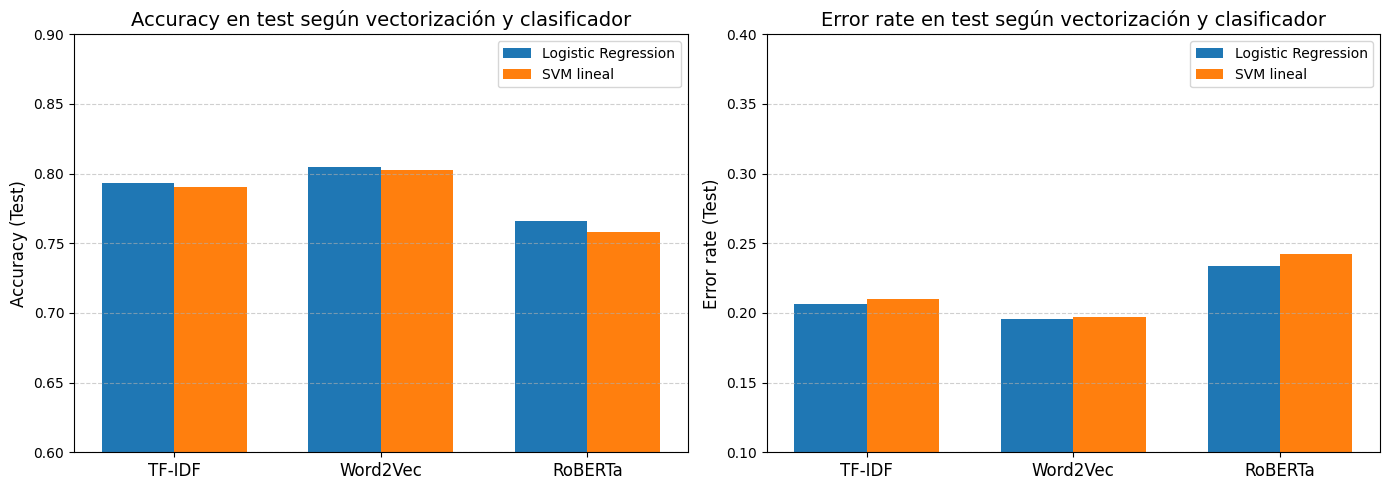

In [ ]:
# Nombres de las representaciones
vectorizaciones = ['TF-IDF', 'Word2Vec', 'RoBERTa']
x = np.arange(len(vectorizaciones))
width = 0.35

# Accuracies en TEST
acc_logreg = [
    acc_tst_tfidf,
    acc_tst_w2v,
    acc_tst_roberta
]

acc_svm = [
    acc_tst_svm_tfidf,
    acc_tst_svm_w2v,
    acc_tst_svm_roberta
]

# Error rates en TEST
err_logreg = [1 - a for a in acc_logreg]
err_svm = [1 - a for a in acc_svm]

# Figura con dos subplots
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)

plt.bar(x - width/2, acc_logreg, width, label='Logistic Regression')
plt.bar(x + width/2, acc_svm, width, label='SVM lineal')
plt.xticks(x, vectorizaciones, fontsize=12)
plt.ylabel('Accuracy (Test)', fontsize=12)
plt.ylim(0.6, 0.9)
plt.title('Accuracy en test según vectorización y clasificador', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Plot Error rate
plt.subplot(1, 2, 2)

plt.bar(x - width/2, err_logreg, width, label='Logistic Regression')
plt.bar(x + width/2, err_svm, width, label='SVM lineal')
plt.xticks(x, vectorizaciones, fontsize=12)
plt.ylabel('Error rate (Test)', fontsize=12)
plt.ylim(0.1, 0.4)
plt.title('Error rate en test según vectorización y clasificador', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Las dos gráficas muestran de forma complementaria el rendimiento de los clasificadores lineales en función de la representación del texto. Tal y como se ha discutido anteriormente, TF-IDF y Word2Vec presentan los valores más altos de accuracy y los menores error rates, mientras que los embeddings contextuales RoBERTa se sitúan ligeramente por debajo en ambos clasificadores.

Estas gráficas refuerzan visualmente las conclusiones obtenidas, evidenciando que el uso de representaciones más complejas no se traduce en mejoras claras cuando se emplean modelos lineales, por lo que para explotar plenamente el potencial de los embeddings contextuales, es necesario recurrir a modelos de clasificación más expresivos que veremos a continuación.



---


##**Redes neuronales**


---



Una vez se ha comprobado que con algoritmos de clasificación de la librería de Scikit-learn las vectorizaciones funcionan y ofrecen resultados relativamente buenos, pasamos a diseñar una red neuronal que se ajuste a nuestro objetivo, distinguir entre noticias verdaderas y falsas.

Para ello, se va a presentar primero la estructura que se ha elegido para nuestra red, y siguiendo la estructura de los apartados anteriores, se analizarán por separado los resultados para cada vectorización para luego presentar unos resultados y conclusiones conjuntos.

In [ ]:
# 3. DEFINIR ARQUITECTURA DE LA RED NEURONAL

print("\n Definiendo arquitectura de red neuronal...")

class NeuralNetworkClassifier(nn.Module):
    """
    Red Neuronal con:
    - Capa de entrada: features del TF-IDF
    - Capas ocultas: 256 → 128 → 64 neuronas con Dropout y ReLU
    - Capa de salida: 3 neuronas (clasificación multiclase)
    """
    def __init__(self, input_size, hidden_size1=1024, hidden_size2=512, hidden_size3=128, dropout=0.4):
    #def __init__(self, input_size, hidden_size1=512, hidden_size2=128, dropout=0.4):

        super(NeuralNetworkClassifier, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)

        dropout -= 0.1
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        dropout -= 0.1
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)

        self.fc4 = nn.Linear(hidden_size3, 1) # 2 clases: true, false

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = self.relu2(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.relu3(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

# Inicializar modelo, pérdida y optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Usando dispositivo: {device}")



 Definiendo arquitectura de red neuronal...
✓ Usando dispositivo: cuda


La clase NeuralNetworkClassifier define una red neuronal densa (Feedforward Neural Network) con múltiples capas ocultas y mecanismos de regularización como Batch Normalization y Dropout para prevenir el sobreajuste.

Capas de entrada y salida: La red está diseñada para una clasificación binaria, con una capa de salida que tiene 1 neurona (para predecir si es verdadero).

Capas ocultas: Consta de tres capas ocultas con 1024, 512 y 128 neuronas respectivamente. Cada capa oculta incluye lo siguiente:

nn.Linear: Una capa completamente conectada que realiza una transformación lineal de las entradas.

nn.BatchNorm1d: Batch Normalization, que normaliza las activaciones de la capa anterior. Esto ayuda a estabilizar el entrenamiento y a acelerar la convergencia.

nn.ReLU: Una función de activación Rectified Linear Unit, que introduce no linealidad en la red, permitiendo aprender relaciones más complejas.

nn.Dropout: Dropout, una técnica de regularización donde, durante el entrenamiento, se ignoran aleatoriamente un porcentaje de neuronas (y sus conexiones) en cada capa. Esto ayuda a prevenir el sobreajuste y a mejorar la generalización del modelo.

ya que predecimos si es verdadera la noticia hemos usado la funcion de perdida BCEWithLogitsLoss ( La clase positiva es implícita cuando el logit es > 0 )



- Combina en una sola operación:

- Sigmoid (convierte el logit a probabilidad entre 0 y 1)

- Binary Cross Entropy Loss





---


Para vectorización TF-IDF


---

batch_size=32 → el modelo verá 32 documentos por iteración

shuffle=True → mezclar el dataset en cada epoch (para mejor entrenamiento)

En validación/test NO se mezcla (shuffle=False)

pos_weigth < 1 penaliza menos cuando falla una positiva (Eso le dice a la red que la clase positiva vale un poco menos que la negativa.)

In [ ]:
# Código RRNN
# Código RRNN para TF-IDF

# 2. CONVERTIR A TENSORES DE PYTORCH
print("\Convirtiendo a tensores de PyTorch...")
X_train_tensor = torch.from_numpy(X_trn_tfidf.toarray()).float()
print(f"X_train_tensor shape: {X_train_tensor.shape}")
y_train_tensor = torch.from_numpy(Y_trn.values.astype(np.int64))

X_val_tensor = torch.from_numpy(X_val_tfidf.toarray()).float()
y_val_tensor = torch.from_numpy(Y_val.values.astype(np.int64))

X_test_tensor = torch.from_numpy(X_tst_tfidf.toarray()).float()
y_test_tensor = torch.from_numpy(Y_tst.values.astype(np.int64))

# Crear DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ DataLoaders creados (batch_size={batch_size})")


print(f"input_size={X_train_tensor.shape[1]}")

model_nn = NeuralNetworkClassifier(input_size=X_train_tensor.shape[1]).to(device)
#criterion = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0]).to(device))
peso_pos = torch.tensor([0.51]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=peso_pos)
optimizer = optim.Adam(model_nn.parameters(), lr=0.0001, weight_decay= 10e-5)
#optimizer = optim.SGD(model_nn.parameters(), lr=0.001)

print("✓ Arquitectura:")
print(model_nn)



\Convirtiendo a tensores de PyTorch...
X_train_tensor shape: torch.Size([1871, 5342])
✓ DataLoaders creados (batch_size=32)
input_size=5342
✓ Arquitectura:
NeuralNetworkClassifier(
  (fc1): Linear(in_features=5342, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.30000000000000004, inplace=False)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.20000000000000004, inplace=False)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:

# 4. FUNCIÓN DE ENTRENAMIENTO
print("\n Entrenando red neuronal...")
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena una época (salida única por ejemplo)"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)            # shape: (batch, 1)
        outputs = outputs.squeeze(1)        # shape: (batch,)
        y_batch_float = y_batch.float()     # BCE expects float targets

        loss = criterion(outputs, y_batch_float)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Estadísticas
        total_loss += loss.item()
        probs = torch.sigmoid(outputs)                # probabilidades
        predicted = (probs > 0.5).long()              # etiquetas predichas 0/1
        correct += (predicted == y_batch.long()).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    """Evalúa el modelo (BCEWithLogitsLoss)"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            outputs = outputs.squeeze(1)
            y_batch_float = y_batch.float()

            loss = criterion(outputs, y_batch_float)

            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()
            correct += (predicted == y_batch.long()).sum().item()
            total += y_batch.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy


# Entrenar el modelo
num_epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model_nn, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_nn, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # # Early Stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     patience_counter = 0
    # else:
    #     patience_counter += 1
    #     if patience_counter >= early_stopping_patience:
    #         print(f"Early stopping en época {epoch+1}")
    #         break

print("✓ Red Neuronal entrenada")



 Entrenando red neuronal...
Época [10/50] - Train Loss: 0.0492, Train Acc: 0.9770 | Val Loss: 0.4768, Val Acc: 0.7580
Época [20/50] - Train Loss: 0.0294, Train Acc: 0.9840 | Val Loss: 0.5850, Val Acc: 0.7644
Época [30/50] - Train Loss: 0.0280, Train Acc: 0.9840 | Val Loss: 0.7356, Val Acc: 0.7676
Época [40/50] - Train Loss: 0.0279, Train Acc: 0.9834 | Val Loss: 0.8363, Val Acc: 0.7564
Época [50/50] - Train Loss: 0.0222, Train Acc: 0.9845 | Val Loss: 0.9410, Val Acc: 0.7532
✓ Red Neuronal entrenada


# Métricas utilizadas

Se presenta a continuación, de forma breve, un resumen de las métricas que se han utilizado para evaluar las prestaciones de la red neuronal, haciendo especial incapié en la matriz de confusión.

## 1. Matriz de confusión (Confusion Matrix)

La **matriz de confusión** es una tabla que muestra el desempeño de un modelo de clasificación:

\
\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}


- **TN (True Negative):** predijo clase 0, era 0  
- **FP (False Positive):** predijo clase 1, era 0  
- **FN (False Negative):** predijo clase 0, era 1  
- **TP (True Positive):** predijo clase 1, era 1  


Otras métricas que se van a utilizar son:

- **Accuracy:** qué % de predicciones totales son correctas  
- **Precision:** de lo que predijo como positivo, qué % era realmente positivo  
- **Recall:** de lo que era positivo, qué % predijo correctamente  
- **F1-score:** balance entre precision y recall  



 Evaluando en conjunto de prueba...
✓ Accuracy:  0.7949
✓ Precision (macro): 0.7785
✓ Recall (macro):    0.7496
✓ F1-Score (macro):  0.7600

Confusion matrix:
 [[129  83]
 [ 45 367]]

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67       212
           1       0.82      0.89      0.85       412

    accuracy                           0.79       624
   macro avg       0.78      0.75      0.76       624
weighted avg       0.79      0.79      0.79       624



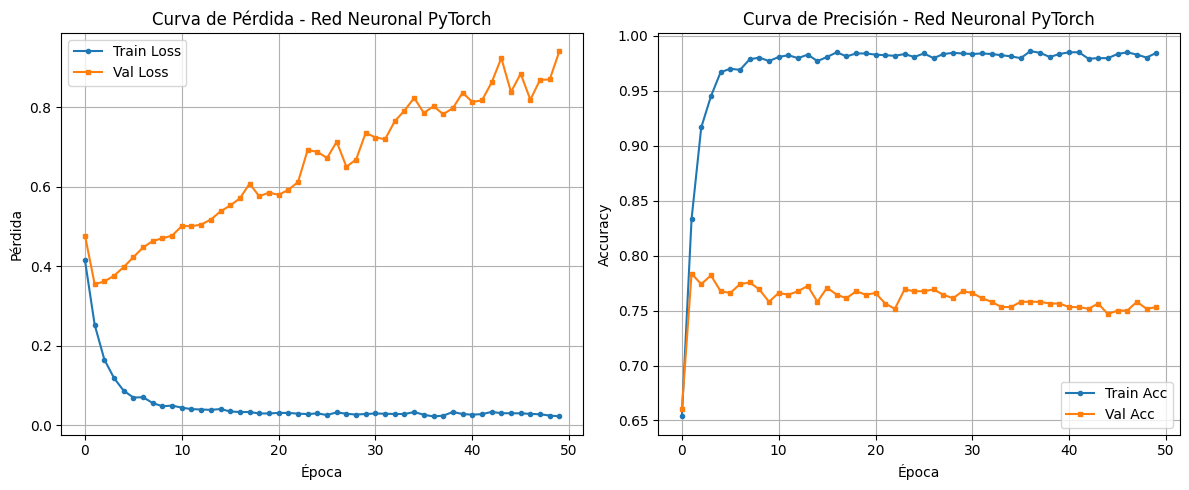

In [ ]:
# Ajusta device si no existe
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_nn.to(device)
model_nn.eval()

print("\n Evaluando en conjunto de prueba...")

y_pred = []
y_true = []
y_score = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model_nn(X_batch)         # (batch,1)
        outputs = outputs.squeeze(1)        # (batch,)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        y_pred.extend(preds.tolist())
        y_score.extend(probs.tolist())

        # aceptar y_batch como integer labels
        if isinstance(y_batch, torch.Tensor):
            true_labels = y_batch.cpu().numpy()
        else:
            true_labels = np.array(y_batch)
        y_true.extend(true_labels.tolist())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
#y_score = np.array(y_score) CLASE POSITIVA

# Métricas multiclas (2 clases)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"✓ Accuracy:  {acc:.4f}")
print(f"✓ Precision (macro): {prec:.4f}")
print(f"✓ Recall (macro):    {rec:.4f}")
print(f"✓ F1-Score (macro):  {f1:.4f}")
print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))

# Visualizar curva de aprendizaje (asegúrate de que existan estas listas: train_losses, val_losses, train_accs, val_accs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(val_losses, label='Val Loss', marker='s', markersize=3)
plt.xlabel('Época'); plt.ylabel('Pérdida')
plt.title('Curva de Pérdida - Red Neuronal PyTorch')
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o', markersize=3)
plt.plot(val_accs, label='Val Acc', marker='s', markersize=3)
plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.title('Curva de Precisión - Red Neuronal PyTorch')
plt.legend(); plt.grid()

plt.tight_layout()
plt.savefig('curva_aprendizaje_nn.png', dpi=100)
plt.show()


En el caso de TF-IDF podemos observar cómo en la matriz de confusión se produce un aumento de Falsos Positivos, es decir, predecimos como positivas noticias falsas. Una métrica importante a tener en cuenta es la F1, ya que es la media armónica entre la precisión y el Recall. Esta métrica nos indica cuán preciso es el modelo sin tener en cuenta el desequilibrio de etiquetas que se encuentran en nuestra base de datos, aunque hayamos hecho una reestructuración de pesos.

In [ ]:
# Guardar valores de la "mejor" época (según val loss y según val acc)

# menor val_loss
best_idx_by_val_loss = int(np.argmin(val_losses))
best_by_val_loss = {
    "epoch": int(best_idx_by_val_loss) + 1,
    "train_loss": float(train_losses[best_idx_by_val_loss]),
    "val_loss": float(val_losses[best_idx_by_val_loss]),
    "train_acc": float(train_accs[best_idx_by_val_loss]),
    "val_acc": float(val_accs[best_idx_by_val_loss])
}

#  mayor val_acc
best_idx_by_val_acc = int(np.argmax(val_accs))
best_by_val_acc = {
    "epoch": int(best_idx_by_val_acc) + 1,
    "train_loss": float(train_losses[best_idx_by_val_acc]),
    "val_loss": float(val_losses[best_idx_by_val_acc]),
    "train_acc": float(train_accs[best_idx_by_val_acc]),
    "val_acc": float(val_accs[best_idx_by_val_acc])
}

# Mostrar resultados
print("Mejor epoch según VAL LOSS:", best_by_val_loss)
print("Mejor epoch según VAL ACC :", best_by_val_acc)



Mejor epoch según VAL LOSS: {'epoch': 2, 'train_loss': 0.25245297005621053, 'val_loss': 0.3545341983437538, 'train_acc': 0.8332442544094067, 'val_acc': 0.7836538461538461}
Mejor epoch según VAL ACC : {'epoch': 2, 'train_loss': 0.25245297005621053, 'val_loss': 0.3545341983437538, 'train_acc': 0.8332442544094067, 'val_acc': 0.7836538461538461}




---


Para vectorización Word2Vec


---

In [ ]:
print("\n Convirtiendo a tensores de PyTorch...")
X_train_tensor = torch.from_numpy(X_trn_w2v).float() # Eliminado .toarray()
print(f"X_train_tensor shape: {X_trn_w2v.shape}")
y_train_tensor = torch.from_numpy(Y_trn.values.astype(np.int64)) # Corregido Y_trn_w2v a Y_trn

X_val_tensor = torch.from_numpy(X_val_w2v).float() # Eliminado .toarray()
y_val_tensor = torch.from_numpy(Y_val.values.astype(np.int64)) # Corregido Y_val_w2v a Y_val

X_test_tensor = torch.from_numpy(X_tst_w2v).float() # Eliminado .toarray()
y_test_tensor = torch.from_numpy(Y_tst.values.astype(np.int64)) # Corregido Y_tst_w2v a Y_tst

# Crear DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ DataLoaders creados (batch_size={batch_size})")


print(f"input_size={X_train_tensor.shape[1]}")

model_nn = NeuralNetworkClassifier(input_size=X_train_tensor.shape[1]).to(device)
#criterion = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0]).to(device))
peso_pos = torch.tensor([0.51]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=peso_pos)
optimizer = optim.Adam(model_nn.parameters(), lr=0.0001, weight_decay= 10e-5)
#optimizer = optim.SGD(model_nn.parameters(), lr=0.001)

print("✓ Arquitectura:")
print(model_nn)


 Convirtiendo a tensores de PyTorch...
X_train_tensor shape: (1871, 100)
✓ DataLoaders creados (batch_size=32)
input_size=100
✓ Arquitectura:
NeuralNetworkClassifier(
  (fc1): Linear(in_features=100, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.30000000000000004, inplace=False)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.20000000000000004, inplace=False)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:

# 4. FUNCIÓN DE ENTRENAMIENTO
print("\n Entrenando red neuronal...")
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena una época (salida única por ejemplo)"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)            # shape: (batch, 1)
        outputs = outputs.squeeze(1)        # shape: (batch,)
        y_batch_float = y_batch.float()     # BCE expects float targets

        loss = criterion(outputs, y_batch_float)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Estadísticas
        total_loss += loss.item()
        probs = torch.sigmoid(outputs)                # probabilidades
        predicted = (probs > 0.5).long()              # etiquetas predichas 0/1
        correct += (predicted == y_batch.long()).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    """Evalúa el modelo (BCEWithLogitsLoss)"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            outputs = outputs.squeeze(1)
            y_batch_float = y_batch.float()

            loss = criterion(outputs, y_batch_float)

            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()
            correct += (predicted == y_batch.long()).sum().item()
            total += y_batch.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy


# Entrenar el modelo
num_epochs = 80
train_losses = []
val_losses = []
train_accs = []
val_accs = []

early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model_nn, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_nn, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # # Early Stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     patience_counter = 0
    # else:
    #     patience_counter += 1
    #     if patience_counter >= early_stopping_patience:
    #         print(f"Early stopping en época {epoch+1}")
    #         break

print("✓ Red Neuronal entrenada")



 Entrenando red neuronal...
Época [10/80] - Train Loss: 0.2840, Train Acc: 0.8038 | Val Loss: 0.3507, Val Acc: 0.7692
Época [20/80] - Train Loss: 0.2445, Train Acc: 0.8332 | Val Loss: 0.3626, Val Acc: 0.7772
Época [30/80] - Train Loss: 0.2074, Train Acc: 0.8642 | Val Loss: 0.3912, Val Acc: 0.7676
Época [40/80] - Train Loss: 0.1803, Train Acc: 0.8894 | Val Loss: 0.4095, Val Acc: 0.7564
Época [50/80] - Train Loss: 0.1620, Train Acc: 0.9001 | Val Loss: 0.4561, Val Acc: 0.7788
Época [60/80] - Train Loss: 0.1575, Train Acc: 0.9017 | Val Loss: 0.4527, Val Acc: 0.7756
Época [70/80] - Train Loss: 0.1258, Train Acc: 0.9241 | Val Loss: 0.5288, Val Acc: 0.7756
Época [80/80] - Train Loss: 0.1206, Train Acc: 0.9225 | Val Loss: 0.5044, Val Acc: 0.7628
✓ Red Neuronal entrenada



[1.5] Evaluando en conjunto de prueba...
✓ Accuracy:  0.7901
✓ Precision (macro): 0.7659
✓ Recall (macro):    0.7712
✓ F1-Score (macro):  0.7684

Confusion matrix:
 [[151  61]
 [ 70 342]]

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.71      0.70       212
           1       0.85      0.83      0.84       412

    accuracy                           0.79       624
   macro avg       0.77      0.77      0.77       624
weighted avg       0.79      0.79      0.79       624



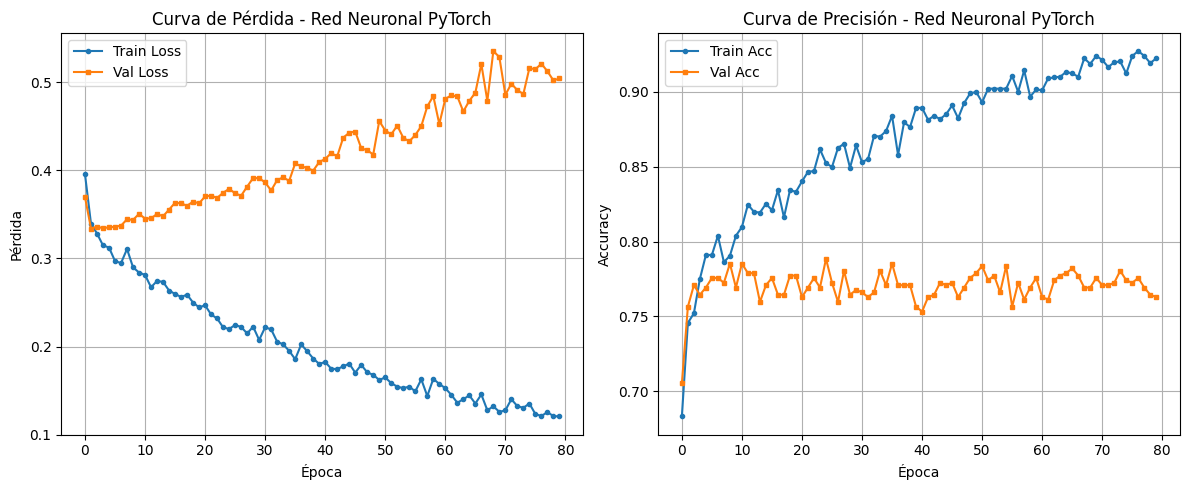

In [ ]:
# Ajusta device si no existe
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_nn.to(device)
model_nn.eval()

print("\n[1.5] Evaluando en conjunto de prueba...")

y_pred = []
y_true = []
y_score = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model_nn(X_batch)         # (batch,1)
        outputs = outputs.squeeze(1)        # (batch,)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        y_pred.extend(preds.tolist())
        y_score.extend(probs.tolist())

        # aceptar y_batch como integer labels
        if isinstance(y_batch, torch.Tensor):
            true_labels = y_batch.cpu().numpy()
        else:
            true_labels = np.array(y_batch)
        y_true.extend(true_labels.tolist())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
#y_score = np.array(y_score) CLASE POSITIVA

# Métricas multiclas (2 clases)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"✓ Accuracy:  {acc:.4f}")
print(f"✓ Precision (macro): {prec:.4f}")
print(f"✓ Recall (macro):    {rec:.4f}")
print(f"✓ F1-Score (macro):  {f1:.4f}")
print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))

# Visualizar curva de aprendizaje (asegúrate de que existan estas listas: train_losses, val_losses, train_accs, val_accs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(val_losses, label='Val Loss', marker='s', markersize=3)
plt.xlabel('Época'); plt.ylabel('Pérdida')
plt.title('Curva de Pérdida - Red Neuronal PyTorch')
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o', markersize=3)
plt.plot(val_accs, label='Val Acc', marker='s', markersize=3)
plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.title('Curva de Precisión - Red Neuronal PyTorch')
plt.legend(); plt.grid()

plt.tight_layout()
plt.savefig('curva_aprendizaje_nn.png', dpi=100)
plt.show()


En el caso de Word2Vec los errores de predicción están más distribuidos entre los FN y FP, es decir que no hay desequilibrio entre clases. El hecho de que Word2Vec capture relaciones semánticas entre palabras puede estar contribuyendo a esta pequeña ventaja sobre TF-IDF.

In [ ]:
import json
import numpy as _np
import torch as _torch

# Guardar valores de la "mejor" época (según val loss y según val acc)

# menor val_loss
best_idx_by_val_loss = int(_np.argmin(val_losses))
best_by_val_loss = {
    "epoch": int(best_idx_by_val_loss) + 1,
    "train_loss": float(train_losses[best_idx_by_val_loss]),
    "val_loss": float(val_losses[best_idx_by_val_loss]),
    "train_acc": float(train_accs[best_idx_by_val_loss]),
    "val_acc": float(val_accs[best_idx_by_val_loss])
}

#  mayor val_acc
best_idx_by_val_acc = int(_np.argmax(val_accs))
best_by_val_acc = {
    "epoch": int(best_idx_by_val_acc) + 1,
    "train_loss": float(train_losses[best_idx_by_val_acc]),
    "val_loss": float(val_losses[best_idx_by_val_acc]),
    "train_acc": float(train_accs[best_idx_by_val_acc]),
    "val_acc": float(val_accs[best_idx_by_val_acc])
}

# Mostrar resultados
print("Mejor epoch según VAL LOSS:", best_by_val_loss)
print("Mejor epoch según VAL ACC :", best_by_val_acc)

# # Guardar métricas en JSON
# results = {"by_val_loss": best_by_val_loss, "by_val_acc": best_by_val_acc}
# with open("best_epoch_metrics.json", "w", encoding="utf-8") as f:
#     json.dump(results, f, ensure_ascii=False, indent=2)

# # Si durante el entrenamiento guardaste el estado del mejor modelo en una variable
# # (p.ej. best_model_state_dict), la guardamos a disco. Si no existe, avisamos.
# if "best_model_state_dict" in globals():
#     _torch.save(best_model_state_dict, "best_model_epoch.pt")
#     print("✓ best_model_state_dict guardado en best_model_epoch.pt")
# else:
#     print("No existe 'best_model_state_dict' en el espac  io de trabajo. "
#           "Si quieres guardar los pesos, modifica el bucle de entrenamiento para guardar "
#           "model.state_dict() cuando val_loss mejore.")

Mejor epoch según VAL LOSS: {'epoch': 2, 'train_loss': 0.33939057361271424, 'val_loss': 0.3339230090379715, 'train_acc': 0.7455905932656334, 'val_acc': 0.7564102564102564}
Mejor epoch según VAL ACC : {'epoch': 25, 'train_loss': 0.21994282178959604, 'val_loss': 0.37909232899546624, 'train_acc': 0.8524853019775521, 'val_acc': 0.7884615384615384}




---


Para vectorización RoBERTa


---

In [ ]:
print("\n Convirtiendo a tensores de PyTorch...")
X_train_tensor = torch.from_numpy(X_trn_w2v).float() # Eliminado .toarray()
print(f"X_train_tensor shape: {X_trn_w2v.shape}")
y_train_tensor = torch.from_numpy(Y_trn.values.astype(np.int64)) # Corregido Y_trn_w2v a Y_trn

X_val_tensor = torch.from_numpy(X_val_w2v).float() # Eliminado .toarray()
y_val_tensor = torch.from_numpy(Y_val.values.astype(np.int64)) # Corregido Y_val_w2v a Y_val

X_test_tensor = torch.from_numpy(X_tst_w2v).float() # Eliminado .toarray()
y_test_tensor = torch.from_numpy(Y_tst.values.astype(np.int64)) # Corregido Y_tst_w2v a Y_tst

# Crear DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ DataLoaders creados (batch_size={batch_size})")


print(f"input_size={X_train_tensor.shape[1]}")

model_nn = NeuralNetworkClassifier(input_size=X_train_tensor.shape[1]).to(device)
#criterion = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0]).to(device))
peso_pos = torch.tensor([0.51]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=peso_pos)
optimizer = optim.Adam(model_nn.parameters(), lr=0.0001, weight_decay= 10e-5)
#optimizer = optim.SGD(model_nn.parameters(), lr=0.001)

print("✓ Arquitectura:")
print(model_nn)


 Convirtiendo a tensores de PyTorch...
X_train_tensor shape: (1871, 100)
✓ DataLoaders creados (batch_size=32)
input_size=100
✓ Arquitectura:
NeuralNetworkClassifier(
  (fc1): Linear(in_features=100, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.30000000000000004, inplace=False)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.20000000000000004, inplace=False)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
# 4. FUNCIÓN DE ENTRENAMIENTO
print("\n Entrenando red neuronal...")
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena una época (salida única por ejemplo)"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)            # shape: (batch, 1)
        outputs = outputs.squeeze(1)        # shape: (batch,)
        y_batch_float = y_batch.float()     # BCE expects float targets

        loss = criterion(outputs, y_batch_float)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Estadísticas
        total_loss += loss.item()
        probs = torch.sigmoid(outputs)                # probabilidades
        predicted = (probs > 0.5).long()              # etiquetas predichas 0/1
        correct += (predicted == y_batch.long()).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    """Evalúa el modelo (BCEWithLogitsLoss)"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            outputs = outputs.squeeze(1)
            y_batch_float = y_batch.float()

            loss = criterion(outputs, y_batch_float)

            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()
            correct += (predicted == y_batch.long()).sum().item()
            total += y_batch.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy


# Entrenar el modelo
num_epochs = 80
train_losses = []
val_losses = []
train_accs = []
val_accs = []

early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model_nn, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_nn, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # # Early Stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     patience_counter = 0
    # else:
    #     patience_counter += 1
    #     if patience_counter >= early_stopping_patience:
    #         print(f"Early stopping en época {epoch+1}")
    #         break

print("✓ Red Neuronal entrenada")



 Entrenando red neuronal...
Época [10/80] - Train Loss: 0.2783, Train Acc: 0.8129 | Val Loss: 0.3390, Val Acc: 0.7724
Época [20/80] - Train Loss: 0.2530, Train Acc: 0.8300 | Val Loss: 0.3523, Val Acc: 0.7837
Época [30/80] - Train Loss: 0.2229, Train Acc: 0.8562 | Val Loss: 0.3848, Val Acc: 0.7821
Época [40/80] - Train Loss: 0.1836, Train Acc: 0.8717 | Val Loss: 0.4214, Val Acc: 0.7756
Época [50/80] - Train Loss: 0.1687, Train Acc: 0.8963 | Val Loss: 0.4376, Val Acc: 0.7676
Época [60/80] - Train Loss: 0.1508, Train Acc: 0.9075 | Val Loss: 0.4708, Val Acc: 0.7724
Época [70/80] - Train Loss: 0.1251, Train Acc: 0.9262 | Val Loss: 0.4925, Val Acc: 0.7804
Época [80/80] - Train Loss: 0.1279, Train Acc: 0.9214 | Val Loss: 0.4924, Val Acc: 0.7644
✓ Red Neuronal entrenada



[1.5] Evaluando en conjunto de prueba...
✓ Accuracy:  0.7869
✓ Precision (macro): 0.7624
✓ Recall (macro):    0.7653
✓ F1-Score (macro):  0.7638

Confusion matrix:
 [[148  64]
 [ 69 343]]

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69       212
           1       0.84      0.83      0.84       412

    accuracy                           0.79       624
   macro avg       0.76      0.77      0.76       624
weighted avg       0.79      0.79      0.79       624



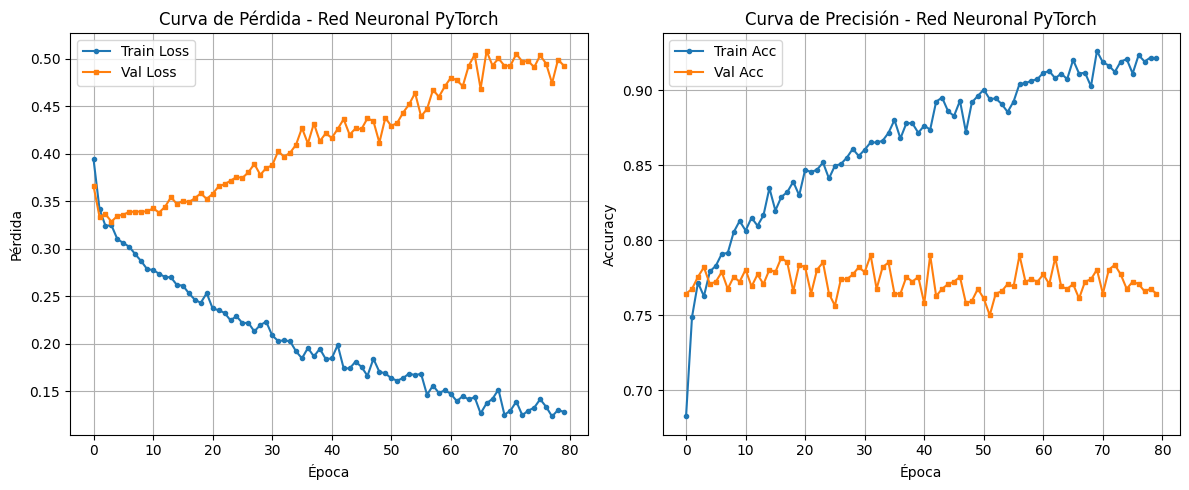

In [ ]:
# Ajusta device si no existe
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_nn.to(device)
model_nn.eval()

print("\n[1.5] Evaluando en conjunto de prueba...")

y_pred = []
y_true = []
y_score = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model_nn(X_batch)         # (batch,1)
        outputs = outputs.squeeze(1)        # (batch,)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        y_pred.extend(preds.tolist())
        y_score.extend(probs.tolist())

        # aceptar y_batch como integer labels
        if isinstance(y_batch, torch.Tensor):
            true_labels = y_batch.cpu().numpy()
        else:
            true_labels = np.array(y_batch)
        y_true.extend(true_labels.tolist())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
#y_score = np.array(y_score) CLASE POSITIVA

# Métricas multiclas (2 clases)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"✓ Accuracy:  {acc:.4f}")
print(f"✓ Precision (macro): {prec:.4f}")
print(f"✓ Recall (macro):    {rec:.4f}")
print(f"✓ F1-Score (macro):  {f1:.4f}")
print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))

# Visualizar curva de aprendizaje (asegúrate de que existan estas listas: train_losses, val_losses, train_accs, val_accs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(val_losses, label='Val Loss', marker='s', markersize=3)
plt.xlabel('Época'); plt.ylabel('Pérdida')
plt.title('Curva de Pérdida - Red Neuronal PyTorch')
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o', markersize=3)
plt.plot(val_accs, label='Val Acc', marker='s', markersize=3)
plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.title('Curva de Precisión - Red Neuronal PyTorch')
plt.legend(); plt.grid()

plt.tight_layout()
plt.savefig('curva_aprendizaje_nn.png', dpi=100)
plt.show()


En este último caso observamos como es bastante similar al caso anterior y que también se distribuyen casi de manera equivalente los FN y FP.

In [ ]:
# Guardar valores de la "mejor" época (según val loss y según val acc)

# menor val_loss
best_idx_by_val_loss = int(_np.argmin(val_losses))
best_by_val_loss = {
    "epoch": int(best_idx_by_val_loss) + 1,
    "train_loss": float(train_losses[best_idx_by_val_loss]),
    "val_loss": float(val_losses[best_idx_by_val_loss]),
    "train_acc": float(train_accs[best_idx_by_val_loss]),
    "val_acc": float(val_accs[best_idx_by_val_loss])
}

#  mayor val_acc
best_idx_by_val_acc = int(_np.argmax(val_accs))
best_by_val_acc = {
    "epoch": int(best_idx_by_val_acc) + 1,
    "train_loss": float(train_losses[best_idx_by_val_acc]),
    "val_loss": float(val_losses[best_idx_by_val_acc]),
    "train_acc": float(train_accs[best_idx_by_val_acc]),
    "val_acc": float(val_accs[best_idx_by_val_acc])
}

# Mostrar resultados
print("Mejor epoch según VAL LOSS:", best_by_val_loss)
print("Mejor epoch según VAL ACC :", best_by_val_acc)

# # Guardar métricas en JSON
# results = {"by_val_loss": best_by_val_loss, "by_val_acc": best_by_val_acc}
# with open("best_epoch_metrics.json", "w", encoding="utf-8") as f:
#     json.dump(results, f, ensure_ascii=False, indent=2)

# # Si durante el entrenamiento guardaste el estado del mejor modelo en una variable
# # (p.ej. best_model_state_dict), la guardamos a disco. Si no existe, avisamos.
# if "best_model_state_dict" in globals():
#     _torch.save(best_model_state_dict, "best_model_epoch.pt")
#     print("✓ best_model_state_dict guardado en best_model_epoch.pt")
# else:
#     print("No existe 'best_model_state_dict' en el espac  io de trabajo. "
#           "Si quieres guardar los pesos, modifica el bucle de entrenamiento para guardar "
#           "model.state_dict() cuando val_loss mejore.")

Mejor epoch según VAL LOSS: {'epoch': 4, 'train_loss': 0.324560690734346, 'val_loss': 0.32836164683103564, 'train_acc': 0.7626937466595404, 'val_acc': 0.782051282051282}
Mejor epoch según VAL ACC : {'epoch': 32, 'train_loss': 0.20274544077909598, 'val_loss': 0.40232661217451093, 'train_acc': 0.8653126670229824, 'val_acc': 0.7900641025641025}


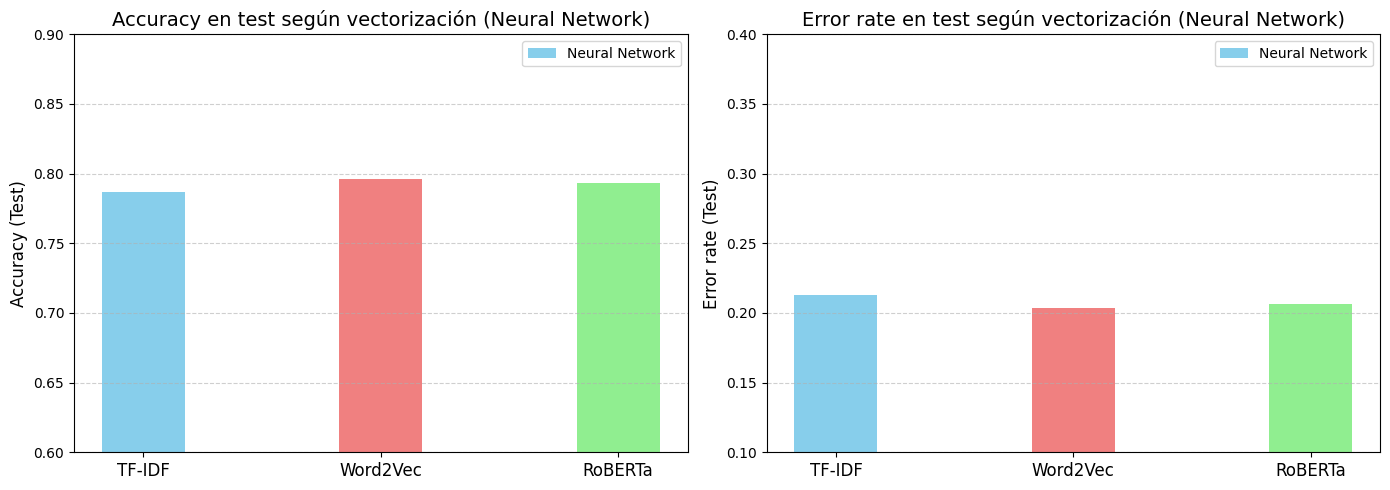

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

vectorizaciones = ['TF-IDF', 'Word2Vec', 'RoBERTa']
x = np.arange(len(vectorizaciones))
width = 0.35

# Accuracies en TEST para Redes Neuronales (extraídas de las salidas anteriores)
acc_nn = [
    0.7868589743589743,
    0.7964743589743589,
    0.7932692307692307
]

# Error rates en TEST para Redes Neuronales
err_nn = [1 - a for a in acc_nn]


colors = ['skyblue', 'lightcoral', 'lightgreen']


plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.bar(x, acc_nn, width, label='Neural Network', color=colors)
plt.xticks(x, vectorizaciones, fontsize=12)
plt.ylabel('Accuracy (Test)', fontsize=12)
plt.ylim(0.6, 0.9)
plt.title('Accuracy en test según vectorización (Neural Network)', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Plot Error rate
plt.subplot(1, 2, 2)
plt.bar(x, err_nn, width, label='Neural Network', color=colors)
plt.xticks(x, vectorizaciones, fontsize=12)
plt.ylabel('Error rate (Test)', fontsize=12)
plt.ylim(0.1, 0.4)
plt.title('Error rate en test según vectorización (Neural Network)', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

A modo de resumen general, los mejores resultados se obtienen con las vectorizaciones más complejas y con más contexto (RoBERTa y Word2Vec). Por otro lado, en el primer modelo TF-IDF vemos ese desequilibrio entre Falsos Positivos y Falsos Negativos, que es un motivo por el cual no tiene tanta precisión el modelo (Predice peor la clase 0). Si nos fijamos en las métricas F1 son bastante similares en todos los modelos; la principal diferencia la marca la clase 0, la cual se predice peor en el TF-IDF como hemos nombrado anteriormente.


---


##**Modelo transformers + Fine-tunning**


---



Para finalizar el tercer apartado, hemos realizado fine-tunning sobre un modelo preentrenado de ROBERTa, que ya hemos visto en la sección 2 que era la que ofrecía mejores prestaciones para nuestro modelo. Destacar que, como en los apartados anteriores, hemos realizado una clasificación true/false, suprimiendo la clase de partially false, que hemos podido comprobar que degrada las prestaciones considerablemente.

Para ello, cargamos el modelo y definimos nuestro problema con 2 etiquetas de salida.

In [ ]:
# Partimos del modelo transformers de Roberta, que era el que mejor funcionaba en el apartado 2

tokenizer=AutoTokenizer.from_pretrained(modelos_transformer["roberta"])

model=AutoModelForSequenceClassification.from_pretrained(
    modelos_transformer["roberta"],
    num_labels=2  # true, false,
)


A continuación, generamos los datasets de entrenamiento, text y validación con las particiones de la base de datos que habíamos establecido en el punto 3.

In [ ]:
train_dataset=Dataset.from_dict({"text": X_trn.tolist(), "labels": Y_trn.tolist()})
val_dataset=Dataset.from_dict({"text": X_val.tolist(), "labels": Y_val.tolist()})
test_dataset=Dataset.from_dict({"text": X_tst.tolist(), "labels": Y_tst.tolist()})


Una vez definido el modelo y los dataset de entrenamiento, test y validación, definimos el tokenizador a utilizar y hallamos los tokens de dicho dataset.

In [ ]:
# A diferencia de la tokenización que hacíamos antes, ahora debemos usar la tokenización interna del modelo

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

In [ ]:
# Tokenizamos todos los elementos del dataset
train_dataset=train_dataset.map(tokenize, batched=True)
val_dataset=val_dataset.map(tokenize, batched=True)
test_dataset=test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/1871 [00:00<?, ? examples/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

In [ ]:
print("Columnas en nuestro dataset de entrenamiento (igual para test y validación)\n")
print(train_dataset.column_names)

# Una vez ya hemos tokenizado, la columna del texto nos sobra, asi que la eliminamos
train_dataset=train_dataset.remove_columns(["text"])
val_dataset=val_dataset.remove_columns(["text"])
test_dataset=test_dataset.remove_columns(["text"])

print("\nNuevas columnas en nuestro dataset de entrenamiento (igual para test y validación)\n")
print(train_dataset.column_names)

# Pasamos los datos a tensores
train_dataset=train_dataset.with_format("torch")
val_dataset=val_dataset.with_format("torch")
test_dataset=test_dataset.with_format("torch")

Columnas en nuestro dataset de entrenamiento (igual para test y validación)

['text', 'labels', 'input_ids', 'attention_mask']

Nuevas columnas en nuestro dataset de entrenamiento (igual para test y validación)

['labels', 'input_ids', 'attention_mask']


El próximo y último paso es entrenar el modelo de ROBERTa de Hugging face. Para ello, definimos un 'entrenador', donde establecemos los parámetros a utilizar en el entrenamiento.

Destacar que se ha utilizado un número de epochs pequeño para reducir el tiempo de ejecución del código ya que hemos visto que 3 epochs eran suficientes para obtener un buen resultado.

In [ ]:
training_args = TrainingArguments(
    output_dir="./roberta_finetuned",
    eval_strategy="epoch", # El modelo se evaluará después de cada epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3, # Número de veces que pasamos todo el dataset al modelo
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    report_to=[]
)


In [ ]:
def compute_metrics(eval_preds):
    '''Evaluation function based on accuracy'''
    pred, labels = eval_preds
    pred = np.argmax(pred, axis=-1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

{'loss': 0.6054, 'grad_norm': 4.134045600891113, 'learning_rate': 1.720797720797721e-05, 'epoch': 0.42735042735042733}
{'loss': 0.5183, 'grad_norm': 5.03524923324585, 'learning_rate': 1.435897435897436e-05, 'epoch': 0.8547008547008547}
{'eval_loss': 0.4769396185874939, 'eval_accuracy': 0.782051282051282, 'eval_runtime': 8.37, 'eval_samples_per_second': 74.552, 'eval_steps_per_second': 4.66, 'epoch': 1.0}
{'loss': 0.4316, 'grad_norm': 7.547885417938232, 'learning_rate': 1.1509971509971511e-05, 'epoch': 1.282051282051282}
{'loss': 0.4433, 'grad_norm': 11.99232006072998, 'learning_rate': 8.660968660968662e-06, 'epoch': 1.7094017094017095}
{'eval_loss': 0.4705057442188263, 'eval_accuracy': 0.8012820512820513, 'eval_runtime': 8.4952, 'eval_samples_per_second': 73.453, 'eval_steps_per_second': 4.591, 'epoch': 2.0}
{'loss': 0.3859, 'grad_norm': 11.815909385681152, 'learning_rate': 5.8119658119658126e-06, 'epoch': 2.1367521367521367}
{'loss': 0.3495, 'grad_norm': 17.983867645263672, 'learning_

TrainOutput(global_step=351, training_loss=0.44206721431169754, metrics={'train_runtime': 334.3466, 'train_samples_per_second': 16.788, 'train_steps_per_second': 1.05, 'train_loss': 0.44206721431169754, 'epoch': 3.0})

In [ ]:
# Evaluación de resultados

prediccion = trainer.predict(test_dataset)
Y_pred = prediccion.predictions.argmax(-1)

print("Accuracy en test:", accuracy_score(Y_tst, Y_pred))
print(classification_report(Y_tst, Y_pred, zero_division=0))

Accuracy en test: 0.7996794871794872
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       212
           1       0.81      0.90      0.86       412

    accuracy                           0.80       624
   macro avg       0.79      0.75      0.76       624
weighted avg       0.80      0.80      0.79       624



Se puede comprobar en el report final como los resultados son buenos, y en el último ejercicio se comparará de forma definitiva con los modelos anteriores.



---


#**EJERCICIO 4: MODELADO Y EVALUACIÓN**


---



A lo largo del notebook y conforme se han ido explicando cada uno de los modelos, se han ido analizando los resultados para cada caso. No obstante, se va a presentar aquí un resumen final de resultados comparando las diferencias de resultados de los modelos de clasificación de Scikit-Learn, la red neuronal y el fine-tunning.

A modo de recordatorio, habíamos visto en el ejercicio 3, después de presentar los modelos de Regresión Logística y SVM, como es con la técnica de vectorización Word2Vec (accuracy en torno al 80% en test) donde se obtienen los mejores resultados, seguido de TF-IDF (accuracy en torno al 78% en test) y finalmente RoBERTa (accuracy en torno al 76% en test). Además, aunque para Word2Vec los resultados para SVM son mejores, para los otros dos métodos el modelo de Regresión Logística, aunque más simple, funciona mejor.

Respecto a las redes neuronales, hemos visto también como los resultados en comparación con los algoritmos anteriores no mejoran especialmente. En términos de accuracy, los resultados son de hecho prácticamente idénticos, obteniéndose con la RRNN el mejor resultado para RoBERTa y, nuevamente, Word2Vec (ya se ha comentado en el punto anterior matrices de confusión obtenidas, etc.).

Finalmente, queda por comparar los resultados respecto al modelo transformers con fine-tunning. Otra vez en términos de accuracy los resultados son muy similares respecto a las dos situaciones anteriores, pero atendiendo a otras métricas como recall y f1-score si que hay algunas pequeñas diferencias respecto a las redes neuronales. Concretamente, el recall para el modelo RoBERTa con fine-tunning es ligeramente superior, es decir, que el porcentaje de noticias verdaderas o falsas que se están detectando realmente es ligeramente superior que la red neuronal. Es por ello que el f1-score también es ligeramente peor que la red neuronal, porque el f1 depende directamente del recall.

A modo de resumen, podemos decir que todos los métodos planteados funcionan correctamente y con diferencias realmente mínimas entre unos y otros. Si hubiera que elegir un solo modelo, es posible que RoBERTa con fine-tunning o la red neuronal con Word2Vec o RoBERTa fueran los que ofrecieran mejores prestaciones y, sobre todo, mayor flexibilidad ante posibles cambios futuros. Hemos visto además como en todos los casos las noticias verdaderas se detectan con mayor facilidad y con menos errores. Como se planteaba en el primer cuaderno, la clase mayoritaria, que es la clase true, se detecta con mayor facilidad.

En cuanto a cómo afecta el 'sentimiento' en el lenguaje o expresiones en las noticias, que también se comentaba en las hipótesis iniciales, será el tema que se tratará a continuación en el proyecto de extensión.



---


#**PROYECTO DE EXTENSIÓN**


---



A modo de extensión, y dado que al principio del trabajo se introducía la idea de que las noticias falsas suelen tener un sentimiento más negativo (se introducía en el primer cuaderno), se va a realizar un estudio del sentimiento que predomina en cada noticia.

Para ello, se van a utilizar las librerias de VADER y Flair, la primera de ellas para extraer el sentimiento de los títulos de las noticias y la segunda para el sentimiento de la noticia.

In [ ]:
!pip install flair -q

from flair.models import TextClassifier
from flair.data import Sentence
from nltk.sentiment.vader import SentimentIntensityAnalyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
titulo=database['title'] # Títulos de las noticias de la base de datos

# Igual que hacíamos con las noticias, limpiamos y homogeneizamos los títulos e incorporamos 2 nuevas columnas a nuestro dataset
# (las noticias limpias y los títulos limpios)
titulo = database['title'].fillna('')
titulo_clean=titulo.apply(remove_html_url)

database['title_clean']=titulo.apply(homogeneizacion)
database['news_clean']=news_clean

Para empezar, vamos a realizar un estudio del sentimiento en los títulos de las noticias, para lo cual empleamos la librería VADER. Esta es una herramienta de análisis de sentimientos basada en léxico y reglas predefinidas que generará para cada título una salida entre -1 (muy negativo) y 1 (muy positivo).

In [ ]:
nltk.download('vader_lexicon')

# Inicializamos VADER
sia = SentimentIntensityAnalyzer()

# VADER utiliza polarity_scores para generar su salida de 'sentimiento'
def sentiment_title(title):
    scores = sia.polarity_scores(title)
    compound = scores['compound']
    if compound >= 0.05:
        sentiment = 'positive'
    elif compound <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
        # Establecemos una tercera etiqueta de neutral si la decisión entre sentimiento
        # positivo y negativo no está clara
    return pd.Series([compound, sentiment])

# Aplicamos VADER a la columna que antes hemos añadido con los títulos limpios
database[['compound_score','sentiment_title']] = database['title_clean'].apply(sentiment_title)

# Agrupamos los títulos por etiquetas (true/false) y determinamos el resultado de sentimiento medio
summary = database.groupby('label').agg({
    'compound_score': 'mean',
}).reset_index()

print("Resumen del sentimiento medio por etiqueta (0=falsa, 1=verdadera):")
print(summary)

# Calculamos el número total de noticias verdaderas y falsas con sentimiento positivo/negativo o neutro
sentiment_dist = database.groupby(['label','sentiment_title']).size().unstack(fill_value=0)
print("\nDistribución de sentimiento por etiqueta:")
print(sentiment_dist)

prop_dist = sentiment_dist.div(sentiment_dist.sum(axis=1), axis=0)
print("\nDistribución porcentual de sentimiento por etiqueta:")
print(prop_dist)



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Resumen del sentimiento medio por etiqueta (0=falsa, 1=verdadera):
   label  compound_score
0      0       -0.065004
1      1       -0.062628

Distribución de sentimiento por etiqueta:
sentiment_title  negative  neutral  positive
label                                       
0                     355      480       223
1                     684      891       486

Distribución porcentual de sentimiento por etiqueta:
sentiment_title  negative   neutral  positive
label                                        
0                0.335539  0.453686  0.210775
1                0.331878  0.432314  0.235808


Podemos ver como para este primer análisis del sentimiento en el título, no se pueden extraer demasiadas conclusiones. Los resultados en la mayoría títulos son con sentimiento neutro y tanto para las noticias positivas como para las negativas, el sentimiento negativo es el que predomina (cosa que era de esperar ya que se están analizando noticias sobre el Covid-19).

Además, esa primera idea de que las noticias falsas suelen tener una componente sentimental más negativa en este caso no se cumple. Para ambas etiquetas (1-*True*,0-*False*), el porcentaje de títulos de noticias con sentimiento positivo o negativo es muy similar.

Dado que el resultado no ha sido determinante con los títulos, vamos a utilizar la librería Flair para analizar el cuerpo de las noticias.

Nota: Se ha utilizado otra librería diferente ya que nuestras noticias son muy largas y los resultados con VADER (cuya salida va de -1 a 1) hemos comprobado que eran mayoritariamente neutros y por tanto poco concluyentes para textos tan largos.

In [ ]:
# Importamos el modelo
classifier = TextClassifier.load('en-sentiment')

def sentiment_flair_news(text):
    if not isinstance(text, str) or text.strip() == "":
        return pd.Series([0.0, 'NEGATIVE']) # Valor por defecto

    sentence = Sentence(text)
    classifier.predict(sentence)

    if len(sentence.labels) == 0:
        return pd.Series([0.0, 'NEGATIVE'])

    label = sentence.labels[0].value # Positivo o negativo
    score = sentence.labels[0].score # Probabilidad

    return pd.Series([score, label])

database[['sentiment_score_flair','sentiment_news_flair']] = database['news_clean'].apply(sentiment_flair_news)


2025-12-12 15:59:13,128 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpjjv2xho4


100%|██████████| 253M/253M [04:01<00:00, 1.10MB/s]

2025-12-12 16:03:14,942 copying /tmp/tmpjjv2xho4 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2025-12-12 16:03:19,411 removing temp file /tmp/tmpjjv2xho4


In [ ]:
# Realizamos la misma agrupación y análisis de resultados que antes

summary_flair = database.groupby('label').agg({
    'sentiment_score_flair': 'mean'
}).reset_index()

print("Resumen del sentimiento de noticias largas (Flair):")
print(summary_flair)

sentiment_dist_flair = database.groupby(['label','sentiment_news_flair']).size().unstack(fill_value=0)
print(sentiment_dist_flair)

sentiment_dist_percent = sentiment_dist_flair.div(sentiment_dist_flair.sum(axis=1), axis=0)
print("\nDistribución porcentual de sentimiento por etiqueta:")
print(sentiment_dist_percent)


Resumen del sentimiento de noticias largas (Flair):
   label  sentiment_score_flair
0      0               0.961254
1      1               0.958029
sentiment_news_flair  NEGATIVE  POSITIVE
label                                   
0                          867       191
1                         1742       319

Distribución porcentual de sentimiento por etiqueta:
sentiment_news_flair  NEGATIVE  POSITIVE
label                                   
0                     0.819471  0.180529
1                     0.845221  0.154779


En este caso, eliminando la etiqueta neutral y estudiando el sentimiento de las noticias al completo basándonos en el lenguaje y expresiones que estas contienen, los resultados son que en alrededor del 80%-85% de las noticias (tanto verdaderas como falsas) el sentimiento negativo es el dominante.

Podemos decir por tanto que, en la base de datos escogida, no existe una diferencia clara entre las noticias verdaderas y falsas atendiendo al lenguaje negativo o polarización catastrofista. Es decir, que la hipótesis de partida que se planteaba (más sentimiento negativo en las noticias falsas) no puede demostrarse que sea cierta atendiendo a los análisis realizados. Si que es cierto que hemos podido ver que hasta en el 85% de las noticias, el sentimiento detectado es negativo.

Por lo tanto, aunque nuestra base de datos estuviera mayoritariamente compuesta por noticias verdaderas y que cabría esperar por tanto un sentimiento general algo más positivo, el resultado es realmente opuesto. Fruto de las complicadas situaciones que dejó la enfermedad del Covid-2019, la mayor parte de las noticias que se publicaban (tanto verdaderas como falsas) eran verdaderamente negativas, luego el lenguaje catastrofista que muchas veces puede poner en duda la veracidad de una noticia, en este caso no es así. Tanto en las noticias verdaderas como las falsas predomina este sentimiento, lo cual dificulta las tareas de clasificación de los modelos anteriormente diseñados y explicados.